<a href="https://colab.research.google.com/github/giovanni-lucarelli/distribution-shift/blob/main/datasetV02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Probabilità condizionata per la variabile target
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

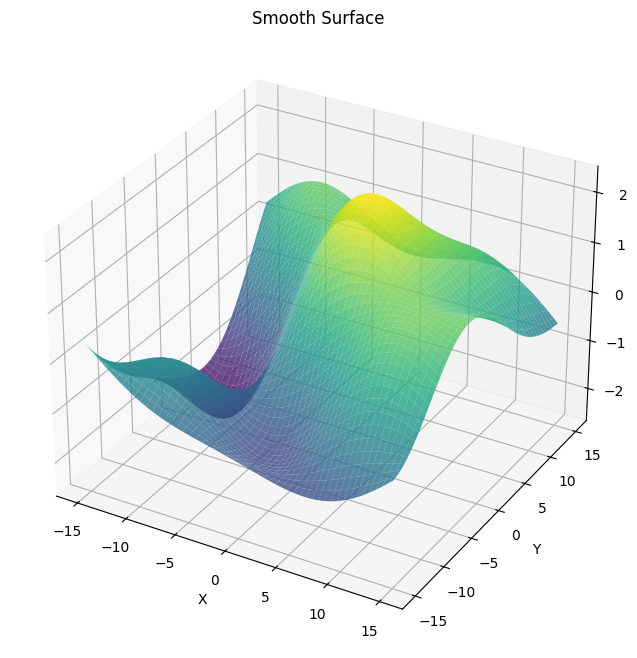

In [3]:
# Function to compute a 2D Fourier series
def fourier_surface(x, y, coefficients):
    """
    Computes a Fourier series-based function of two variables.
    :param x: Array of x values.
    :param y: Array of y values.
    :param coefficients: List of tuples (a_k, b_k, c_k) for terms in the series.
    :return: A 2D array representing the surface values.
    """
    z = np.zeros_like(x)
    for (k_x, k_y, a_k, b_k, c_k) in coefficients:
        z += a_k * np.sin(k_x * x + c_k) * np.cos(k_y * y) + b_k * np.cos(k_x * x) * np.sin(k_y * y + c_k)
    return z

# Create a grid of x and y values
x = np.linspace(-15, 15, 200)  # Adjusted the range to fit the larger period
y = np.linspace(-15, 15, 200)
X, Y = np.meshgrid(x, y)

# Define coefficients for the Fourier series with smaller k_x and k_y for larger periods
coefficients = [
    (0.1, 0.1, 1.0, 0.8, 0.0),   # k_x = 0.1, k_y = 0.1 (large period)
    (0.2, 0.1, 0.5, 0.4, np.pi / 4),  # k_x = 0.2, k_y = 0.1
    (0.1, 0.2, 0.6, 0.3, np.pi / 6),  # k_x = 0.1, k_y = 0.2
    (0.3, 0.3, 0.2, 0.7, np.pi / 3),  # k_x = 0.3, k_y = 0.3
    (0.2, 0.3, 0.3, 0.2, -np.pi / 4)  # k_x = 0.2, k_y = 0.3
]

# Compute the surface values
Z = fourier_surface(X, Y, coefficients)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Smooth Surface')
plt.show()


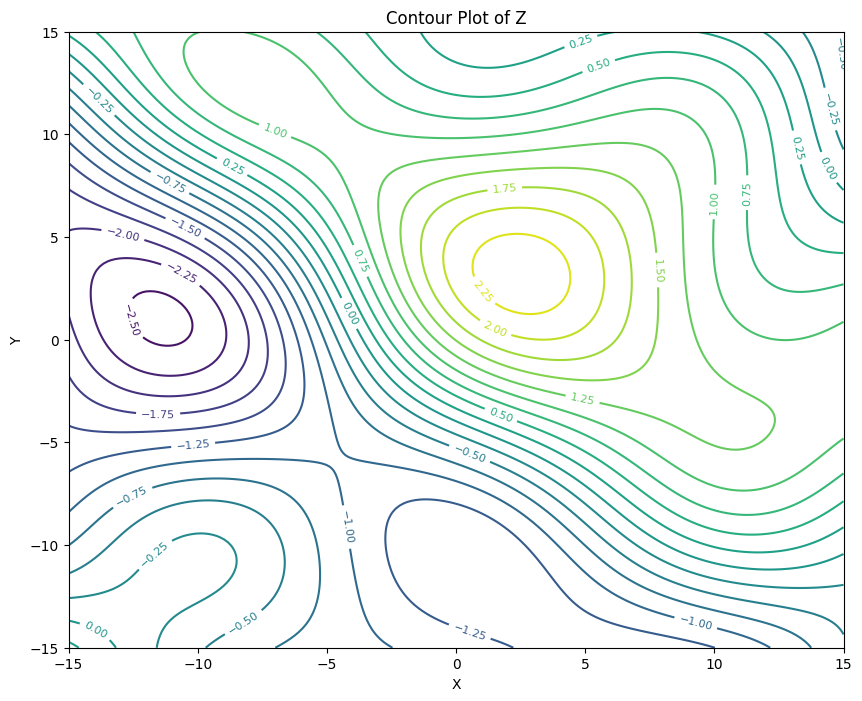

In [4]:
plt.figure(figsize=(10,8))
contour = plt.contour(X,Y,Z, levels=20) # Adjust levels as needed
plt.clabel(contour, inline=1, fontsize=8)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot of Z')
plt.show()

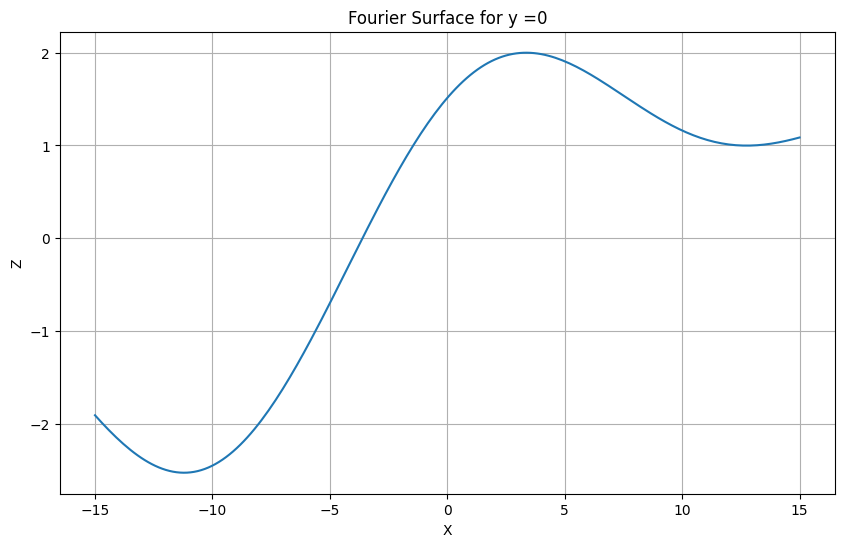

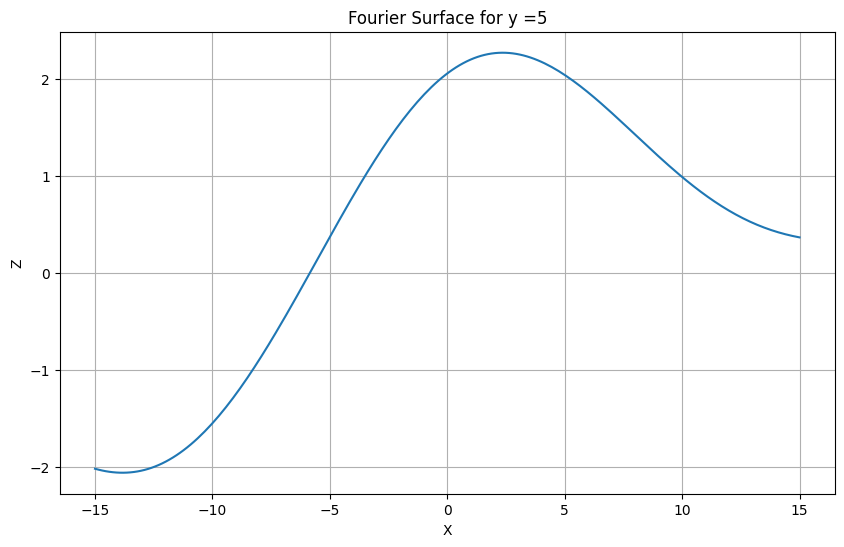

In [ ]:
# Plot the Fourier surface for fixed y
y_zero = 0
z_y_zero = fourier_surface(x, np.full_like(x, y_zero), coefficients)

plt.figure(figsize=(10, 6))
plt.plot(x, z_y_zero)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Fourier Surface for y ='+str(y_zero))
plt.grid(True)
plt.show()


# Plot the Fourier surface for fixed y
y_zero = 5
z_y_zero = fourier_surface(x, np.full_like(x, y_zero), coefficients)

plt.figure(figsize=(10, 6))
plt.plot(x, z_y_zero)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Fourier Surface for y ='+str(y_zero))
plt.grid(True)
plt.show()

**Osservazione:** bisogna stare attenti alla periodicità, altrimenti la generalizzazione è banale

In [19]:
# Parametri della normale bivariata
mean = [-5, 0]  # Medie
cov = [[5, 0.8], [0.8, 5]]  # Matrice di covarianza

# Generazione di una nuova bivariata
mean2 = [-2, 0]
cov2 = [[4, -0.3], [-0.3, 4]]

In [23]:
# Mixing probability
pi = 1.  # Probability of drawing from the first distribution

# Number of samples
N = 1000

# Generate samples
x_mix = [] # Initialize as lists
y_mix = []
for i in range(N):
  choice = np.random.choice([1, 0], 1, p=[pi, 1-pi])
  if choice == 0:
    x, y = np.random.multivariate_normal(mean, cov, 1).T # Generate 1 sample
    x_mix.extend(x) # Append to lists
    y_mix.extend(y)
  else:
    x, y = np.random.multivariate_normal(mean2, cov2, 1).T # Generate 1 sample
    x_mix.extend(x) # Append to lists
    y_mix.extend(y)

x_mix = np.array(x_mix) # Convert to numpy arrays
y_mix = np.array(y_mix)

In [24]:
# Generating target variable
z_mix = fourier_surface(x_mix, y_mix, coefficients)

# gaussian (irreducible) error
noise_std = 0.05  # Deviazione standard del rumore
epsilon = np.random.normal(0, noise_std, size=z_mix.shape)
z_mix_noisy = z_mix + epsilon

# Probabilità condizionata per i nuovi dati
prob_t1_mix = sigmoid(z_mix_noisy)

# Campionamento della variabile target per i nuovi dati
t_mix = np.random.binomial(1, prob_t1_mix)

# Creazione del DataFrame combinato
df_mix = pd.DataFrame({'x': x_mix, 'y': y_mix, 'z': z_mix_noisy, 't': t_mix})
print(df_mix.head())


          x         y         z  t
0 -0.635150 -1.669042  0.679936  1
1 -1.694255 -0.649236  0.731303  0
2 -3.241162  1.136531  0.456490  1
3 -2.979193 -3.026811 -0.485976  0
4 -1.729821  1.728351  1.368835  1


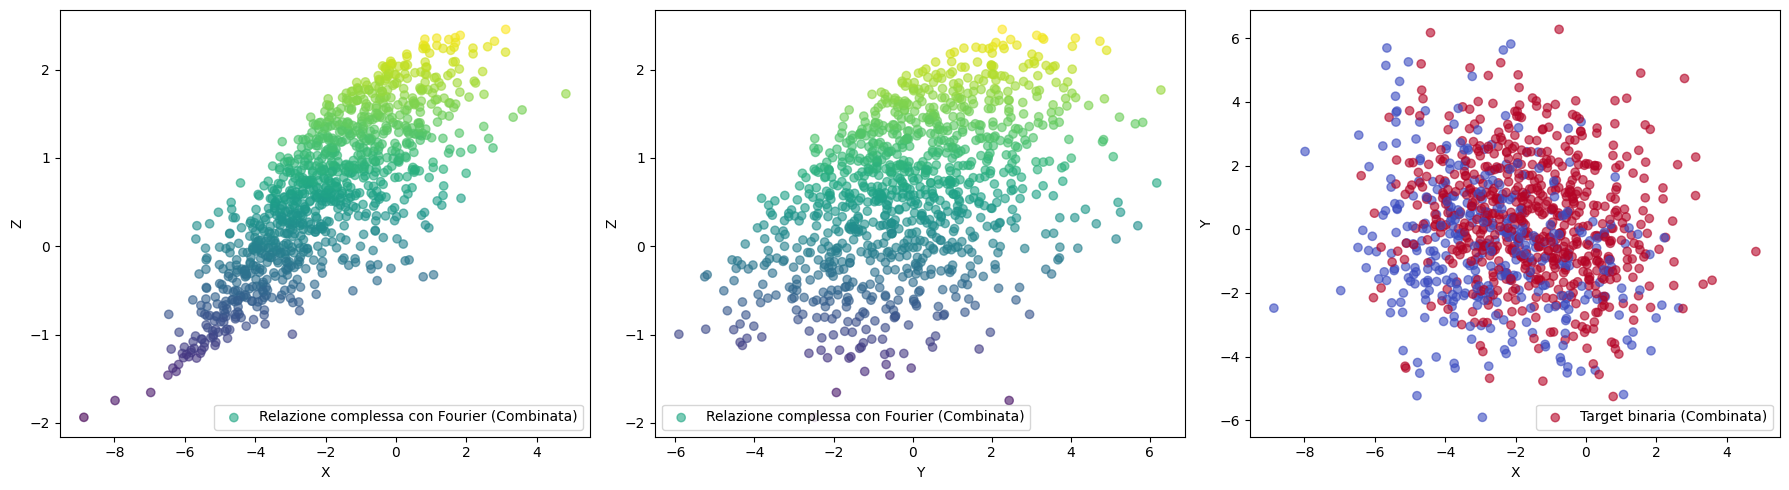

In [25]:
# Visualizzazione combinata
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(x_mix, z_mix_noisy, alpha=0.6, c=z_mix_noisy, label="Relazione complessa con Fourier (Combinata)")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Z")
axs[0].legend()

axs[1].scatter(y_mix, z_mix_noisy, alpha=0.6, c=z_mix_noisy, label="Relazione complessa con Fourier (Combinata)")
axs[1].set_xlabel("Y")
axs[1].set_ylabel("Z")
axs[1].legend()

axs[2].scatter(x_mix, y_mix, c=t_mix, cmap='coolwarm', alpha=0.6, label="Target binaria (Combinata)")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
axs[2].legend()

plt.tight_layout()
plt.show()

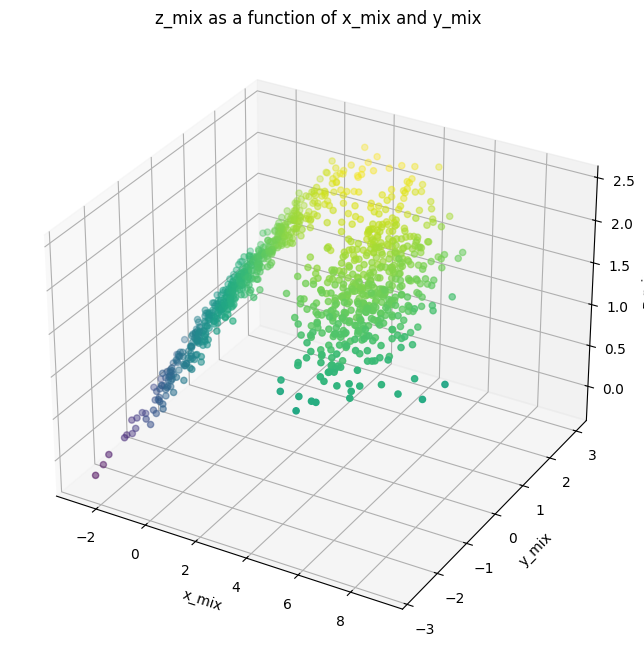

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_mix, y_mix, z_mix_noisy, c=z_mix, cmap='viridis')
ax.set_xlabel('x_mix')
ax.set_ylabel('y_mix')
ax.set_zlabel('z_mix')
ax.set_title('z_mix as a function of x_mix and y_mix')
plt.show()

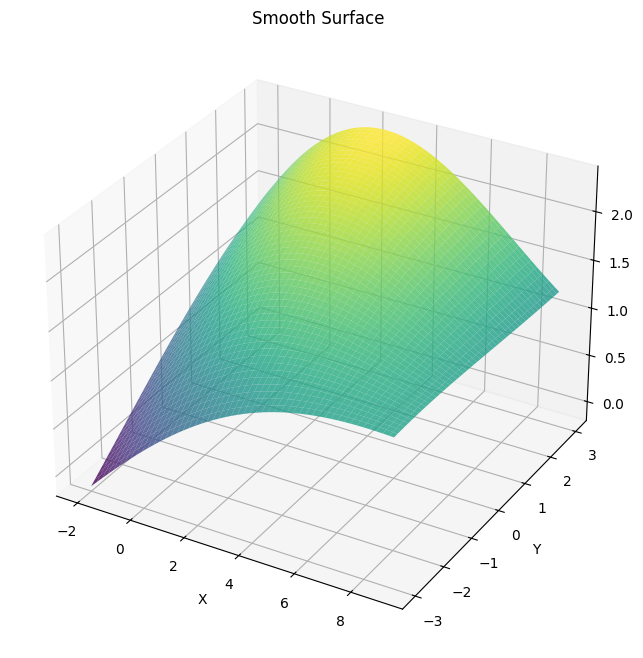

In [ ]:
# Create a grid of x and y values
x = np.linspace(-2,9, 200)  # Adjusted the range to fit the larger period
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)

# Compute the surface values
Z = fourier_surface(X, Y, coefficients)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Smooth Surface')
plt.show()

In [ ]:
for pi in [0.,0.2,0.4,0.6,0.8,1.]:
  # Number of samples
  N = 1000

  # Generate samples
  x_mix = [] # Initialize as lists
  y_mix = []
  for i in range(N):
    choice = np.random.choice([1, 0], 1, p=[pi, 1-pi])
    if choice == 0:
      x, y = np.random.multivariate_normal(mean, cov, 1).T # Generate 1 sample
      x_mix.extend(x) # Append to lists
      y_mix.extend(y)
    else:
      x, y = np.random.multivariate_normal(mean2, cov2, 1).T # Generate 1 sample
      x_mix.extend(x) # Append to lists
      y_mix.extend(y)

  x_mix = np.array(x_mix) # Convert to numpy arrays
  y_mix = np.array(y_mix)

  # Generating target variable
  z_mix = fourier_surface(x_mix, y_mix, coefficients)

  # gaussian (irreducible) error
  noise_std = 0.05  # Deviazione standard del rumore
  epsilon = np.random.normal(0, noise_std, size=z_mix.shape)
  z_mix_noisy = z_mix + epsilon

  # Probabilità condizionata per i nuovi dati
  prob_t1_mix = sigmoid(z_mix_noisy)

  # Campionamento della variabile target per i nuovi dati
  t_mix = np.random.binomial(1, prob_t1_mix)

  # Creazione del DataFrame combinato
  df_mix = pd.DataFrame({'x': x_mix, 'y': y_mix, 'z': z_mix_noisy, 't': t_mix})

  df_mix.to_csv('df_mix'+str(pi)+'.csv', index=False)



New version, without mixtures

we can both:

*   train on the original and test only on the shifted
*   train on various mixture and test only on the shifted to see how performance increases

we can start with the firts one.



In [76]:
N = 1000

# Parametri della normale bivariata
mean = [0, 0]  # Medie
cov = [[5, 0.8], [0.8, 3]]  # Matrice di covarianza

x, y = np.random.multivariate_normal(mean, cov, N).T

from scipy.stats import norm

# Calculate the quantile for each dimension separately using scipy.stats.norm
theo_quantile_x = norm.ppf(0.95, loc=mean[0], scale=np.sqrt(cov[0][0]))
theo_quantile_y = norm.ppf(0.95, loc=mean[1], scale=np.sqrt(cov[1][1]))

print(f"The 90% quantile for X is: {theo_quantile_x}")
print(f"The 90% quantile for Y is: {theo_quantile_y}")

The 90% quantile for X is: 3.6780045229005722
The 90% quantile for Y is: 2.848970052893894


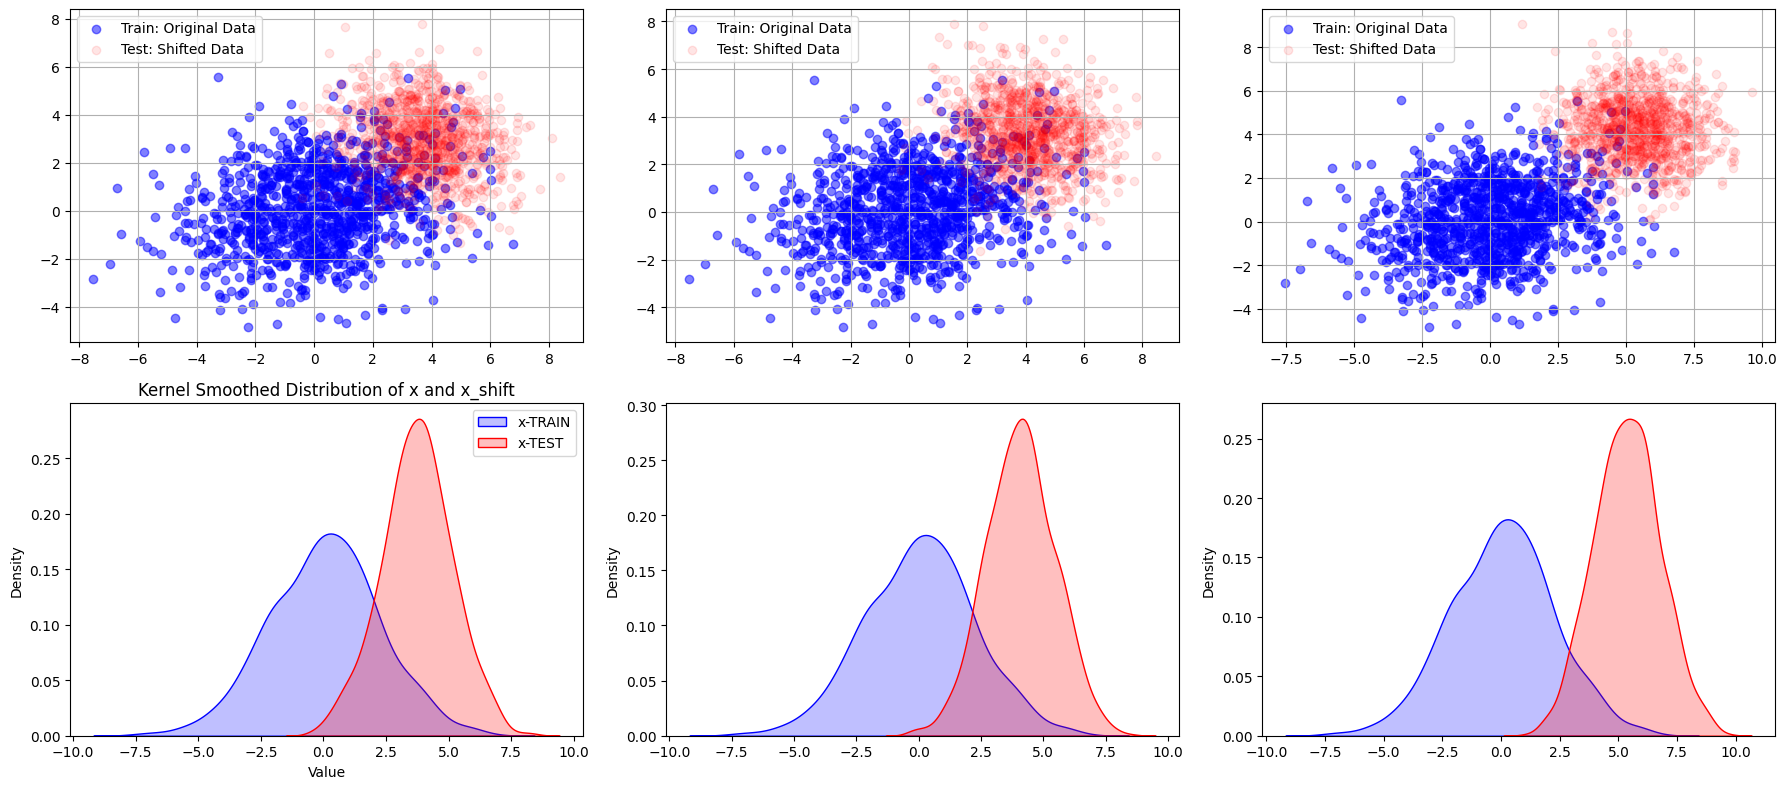

In [83]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # Adjust figsize as needed

# Calculate the empirical quantile
quantile_x = np.quantile(x, 0.95)
quantile_y = np.quantile(y, 0.95)
# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]
cov_shift = [[2, -0.3], [-0.3, 2]]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Plot 1
axs[0,0].scatter(x, y, color='blue', label='Train: Original Data', alpha=0.5)
axs[0,0].scatter(x_shift, y_shift, color='red', label='Test: Shifted Data', alpha=0.1)
axs[0,0].legend()
axs[0,0].grid(True)

sns.kdeplot(x, color='blue', label='x-TRAIN', fill=True,ax=axs[1, 0])
sns.kdeplot(x_shift, color='red', label='x-TEST', fill=True,ax=axs[1, 0])
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Density')
axs[1, 0].set_title('Kernel Smoothed Distribution of x and x_shift')
axs[1, 0].legend()
# Calculate the empirical quantile
quantile_x = np.quantile(x, 0.97)
quantile_y = np.quantile(y, 0.97)
# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]
cov_shift = [[2, -0.3], [-0.3, 2]]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Plot 2
axs[0,1].scatter(x, y, color='blue', label='Train: Original Data', alpha=0.5)
axs[0,1].scatter(x_shift, y_shift, color='red', label='Test: Shifted Data', alpha=0.1)
axs[0,1].legend()
axs[0,1].grid(True)

sns.kdeplot(x, color='blue', label='x-TRAIN', fill=True,ax=axs[1, 1])
sns.kdeplot(x_shift, color='red', label='x-TEST', fill=True,ax=axs[1, 1])

# Calculate the empirical quantile
quantile_x = np.quantile(x, 0.99)
quantile_y = np.quantile(y, 0.99)
# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]
cov_shift = [[2, -0.3], [-0.3, 2]]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Plot 3
axs[0,2].scatter(x, y, color='blue', label='Train: Original Data', alpha=0.5)
axs[0,2].scatter(x_shift, y_shift, color='red', label='Test: Shifted Data', alpha=0.1)
axs[0,2].legend()
axs[0,2].grid(True)

sns.kdeplot(x, color='blue', label='x-TRAIN', fill=True,ax=axs[1, 2])
sns.kdeplot(x_shift, color='red', label='x-TEST', fill=True,ax=axs[1, 2])

plt.tight_layout()
plt.show()